In [1]:
# Import libraries
import os
import shutil
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Get a list of GPU devices
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Enable memory growth for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # After enabling memory growth, we need to make sure TensorFlow sees the updated configuration
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error setting memory growth: {e}")

1 Physical GPUs, 1 Logical GPUs


# Deal with class assignment for images.

# Paths to your dataset and CSV files
train_dataset_dir = "CarRecognition\cars_train"  # Replace with the path to your training images directory
test_dataset_dir = "CarRecognition\cars_test"    # Replace with the path to your testing images directory
output_dir = "CarRecognition\organized_cars"  # Directory where the organized dataset will be stored
train_csv = "CarRecognition\cars_annos_train.csv"  # Path to your train CSV
test_csv = "CarRecognition\cars_annos_test.csv"    # Path to your test CSV

# Function to organize images based on a CSV file
def organize_images(csv_file, dataset_dir, output_dir):
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    for _, row in df.iterrows():
        image_name = row['image']
        class_id = row['class']
        
        # Create a subdirectory for the class
        class_dir = os.path.join(output_dir, str(class_id))
        os.makedirs(class_dir, exist_ok=True)
        
        # Move the image to the class subdirectory
        src_path = os.path.join(dataset_dir, image_name)
        dst_path = os.path.join(class_dir, image_name)
        if os.path.exists(src_path):
            shutil.move(src_path, dst_path)
        else:
            print(f"Image not found: {src_path}")

# Organize train and test datasets
organize_images(train_csv, train_dataset_dir, os.path.join(output_dir, "train"))
organize_images(test_csv, test_dataset_dir, os.path.join(output_dir, "test"))

print("Dataset organization complete!")

In [3]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.

# Use forward slashes for paths - works on all platforms including Windows
training_dir = r'CarRecognition\organized_cars\test'
testing_dir = r'CarRecognition\organized_cars\train'
image_size = (256, 256)

# Create a single ImageDataGenerator with our configurations
data_generator = ImageDataGenerator(
        rescale=1./255,
        )

# Create separate generators for training and validation from the same ImageDataGenerator
train_generator = data_generator.flow_from_directory(
    training_dir,  # Replace with the path to your training data
    target_size=(224, 224),  # Adjust to your input size
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' for integer labels
    seed=42
)

validation_generator = data_generator.flow_from_directory(
        testing_dir,
        batch_size=32,
        class_mode='sparse',
        seed=42)

Found 8041 images belonging to 196 classes.
Found 8144 images belonging to 196 classes.


Class names: ['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', 

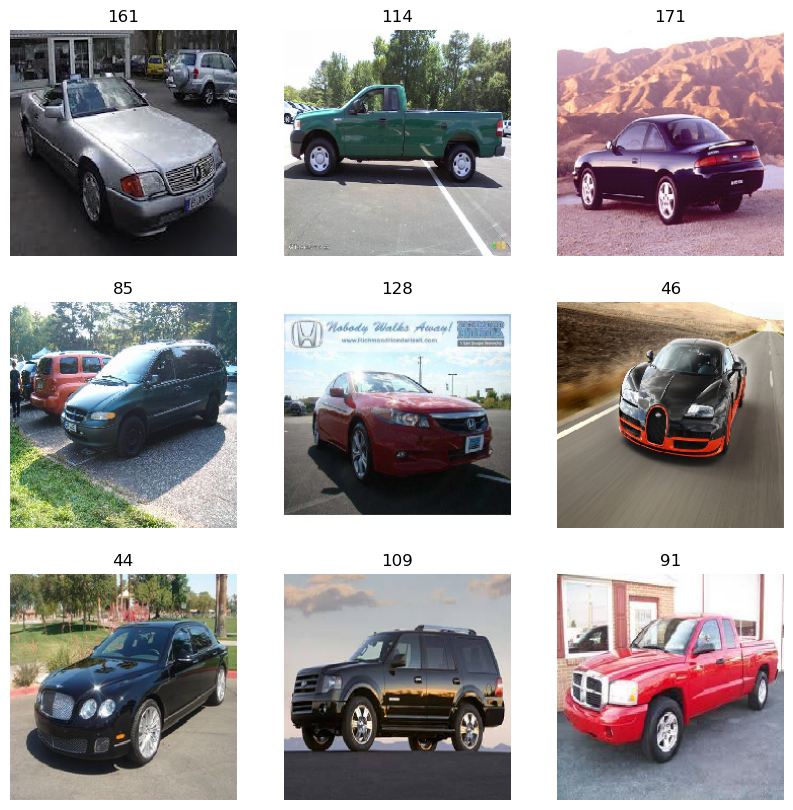

In [ ]:
# Extract class names from train_generator
target_names = list(train_generator.class_indices.keys())
print("Class names:", target_names)

# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Get the first batch
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    
    # Map the class ID to the class name using target_names
    class_id = int(labels[i])
    class_name = target_names[class_id]
    
    plt.title(class_name)
    plt.axis("off")

plt.show()

In [5]:
# Build a model...

# Load the pretrained ResNet-50 without top layers.
base_model = tf.keras.applications.densenet.DenseNet169(include_top=False, input_shape=None, classes=196)

# Adding custom layers on the pretrained model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(target_names))  # Output layer
])

#Compile the model
model.compile(optimizer = Adam(learning_rate=1e-4), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

model.summary()

# Check your class count
print(f"Number of classes in train_generator: {len(train_generator.class_indices)}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, None, None, 1664)  12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               50372     
Total params: 13,119,492
Trainable params: 12,961,092
Non-trainable params: 158,400
_________________________________________________________________
Number of classes in train_generator: 196


In [ ]:
# Create callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will stop
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

checkpoint = ModelCheckpoint(
    'CarRecognition\car_predictor.h5',     # Path to save the best model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
252/252 [==============================] - 135s 534ms/step - loss: 5.1301 - accuracy: 0.0293 - val_loss: 4.7071 - val_accuracy: 0.0907

Epoch 00001: val_loss improved from inf to 4.70707, saving model to car_predictor.h5
Epoch 2/10
252/252 [==============================] - 65s 258ms/step - loss: 4.0114 - accuracy: 0.1676 - val_loss: 3.3491 - val_accuracy: 0.3815

Epoch 00002: val_loss improved from 4.70707 to 3.34907, saving model to car_predictor.h5
Epoch 3/10
252/252 [==============================] - 66s 264ms/step - loss: 2.7096 - accuracy: 0.3899 - val_loss: 2.4117 - val_accuracy: 0.5543

Epoch 00003: val_loss improved from 3.34907 to 2.41165, saving model to car_predictor.h5
Epoch 4/10
252/252 [==============================] - 67s 267ms/step - loss: 1.6285 - accuracy: 0.6290 - val_loss: 1.7240 - val_accuracy: 0.6562

Epoch 00004: val_loss improved from 2.41165 to 1.72403, saving model to car_predictor.h5
Epoch 5/10
252/252 [==============================] - 66s 261ms

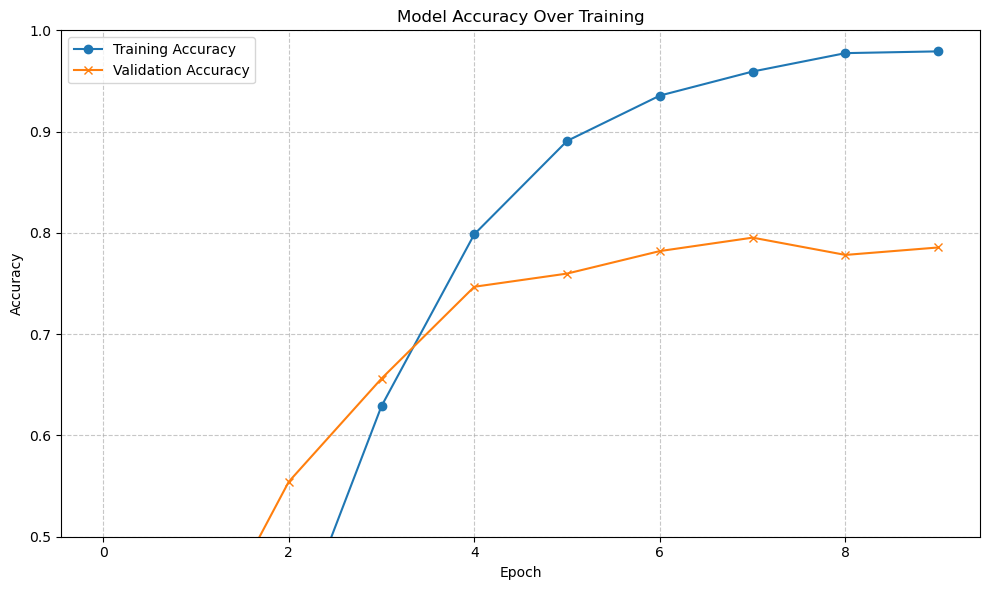

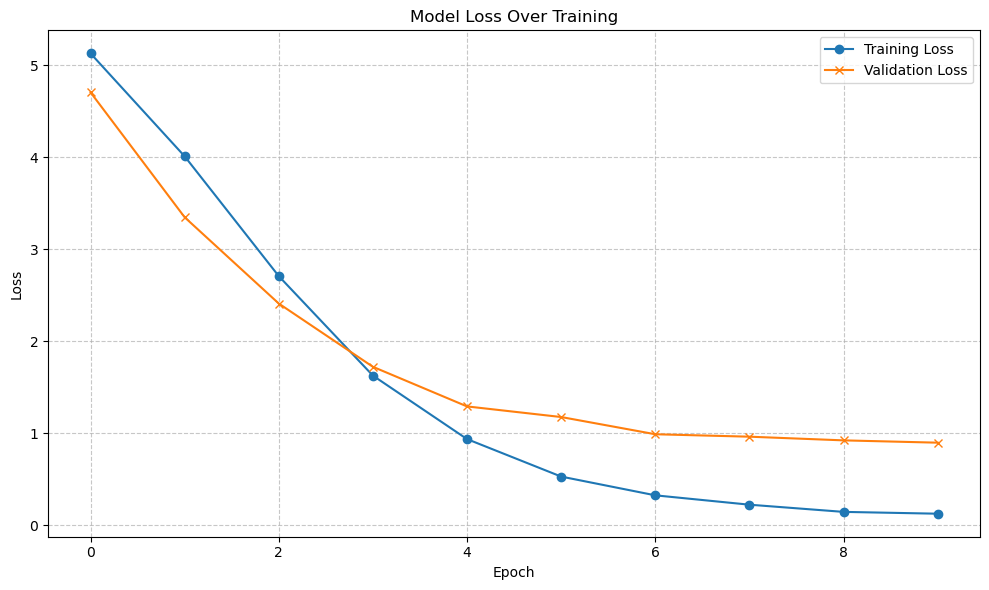

255/255 - 30s - loss: 0.8995 - accuracy: 0.7856
Test accuracy: 0.7856
Test loss: 0.8995


In [8]:
# Create a new figure with a specific size
plt.figure(figsize=(10, 6))

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Training')
plt.ylim([0.50, 1])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left')

# Force display the plot
plt.tight_layout()
plt.show()

# Create a new figure for loss
plt.figure(figsize=(10, 6))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Training')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')

# Force display the plot
plt.tight_layout()
plt.show()

# Print evaluation metrics
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")